In [1]:
# Load all the things
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz

In [2]:
# Path to feems_data folder which has the global grid and dingo_data which has genotypes and sample locations
feems_data = pkg_resources.resource_filename("feems", "data/")
dingo_data = "/gpfs/users/a1880987/projects/dingo/feems/"

In [3]:
# Read plink genotypes.
(bim, fam, G) = read_plink("{}/SNPArray_Dingo_w_coords".format(dingo_data))

# I do not want to impute genotypes, I have removed SNPs with any missing data instead. 
#imp = SimpleImputer(missing_values=np.nan, strategy="mean")
#genotypes = imp.fit_transform((np.array(G)).T)

genotypes = np.array(G).T
print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.97it/s]


n_samples=219, n_snps=78689


In [4]:
# Get the required files
coord = np.loadtxt("{}/SNPArray_Dingo_w_coords.coord".format(dingo_data))  # sample coordinates
outer = np.loadtxt("{}/SNPArray_Dingo_w_coords.outer".format(dingo_data))  # outer coordinates of Australia
grid_path = "{}/grid_100.shp".format(feems_data)  # path to discrete global grid

In [5]:
# graph input files
outer_processed, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             outer=outer,
                                             buffer=1)

In [6]:
## Make it as a graph
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

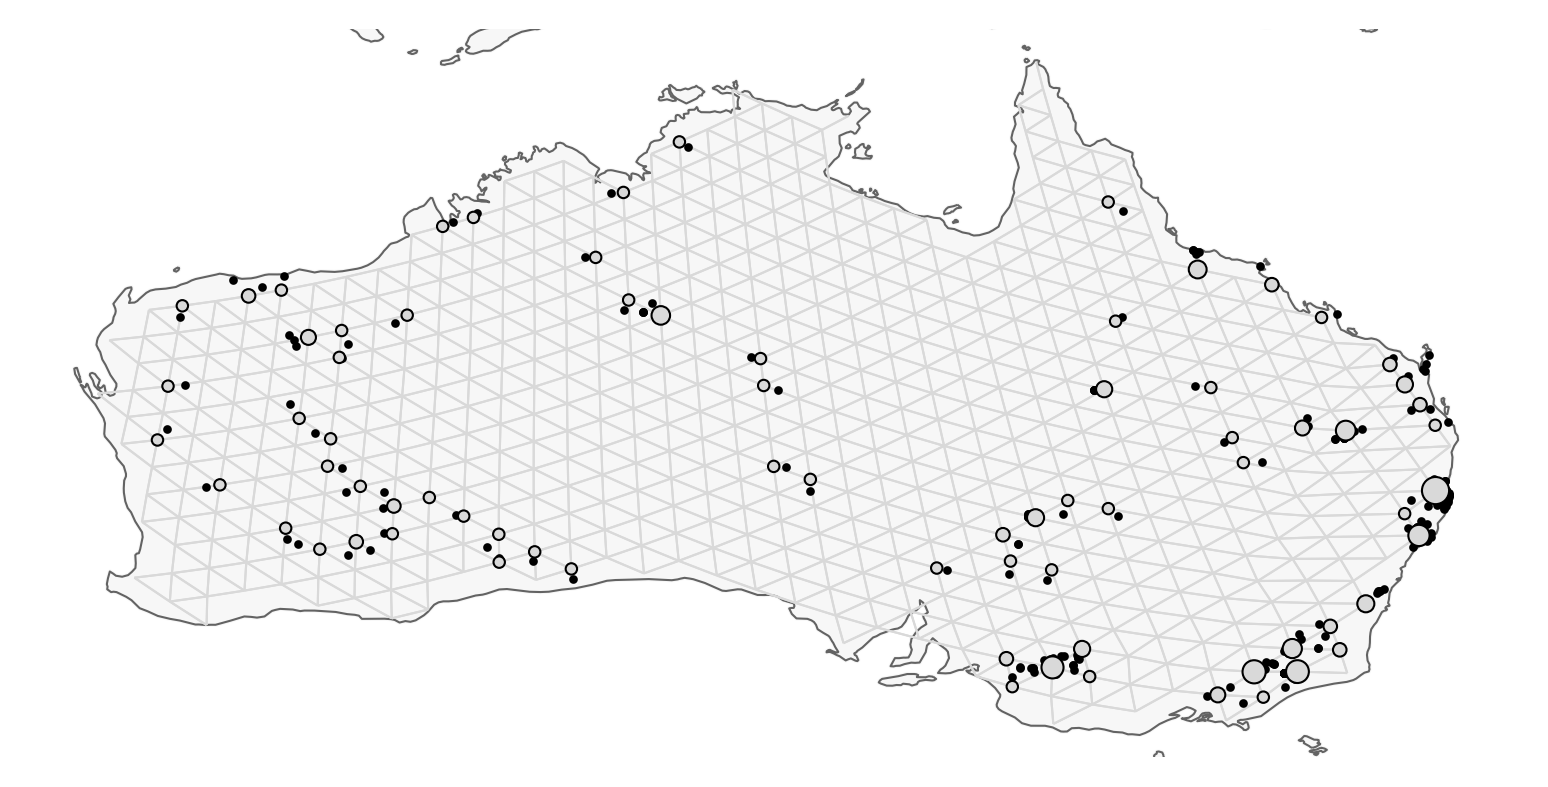

In [7]:
# Plot things to make sure they look correct
projection = ccrs.EquidistantConic(central_longitude=132.78, central_latitude=-25.38)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [8]:
%%time
sp_graph.fit(lamb = 2.0, verbose=True) # Calculate effective gene flow between the edges using lamb=2.0. 
# No idea if the lamb value is sensible. May be worth to play around. 
# Paper indicates it is okay. 

constant-w/variance fit, converged in 133 iterations, train_loss=8069343.8458551
lambda=2.0000000, alpha=1.1645479, converged in 217 iterations, train_loss=7363737.5794622
CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.76 s


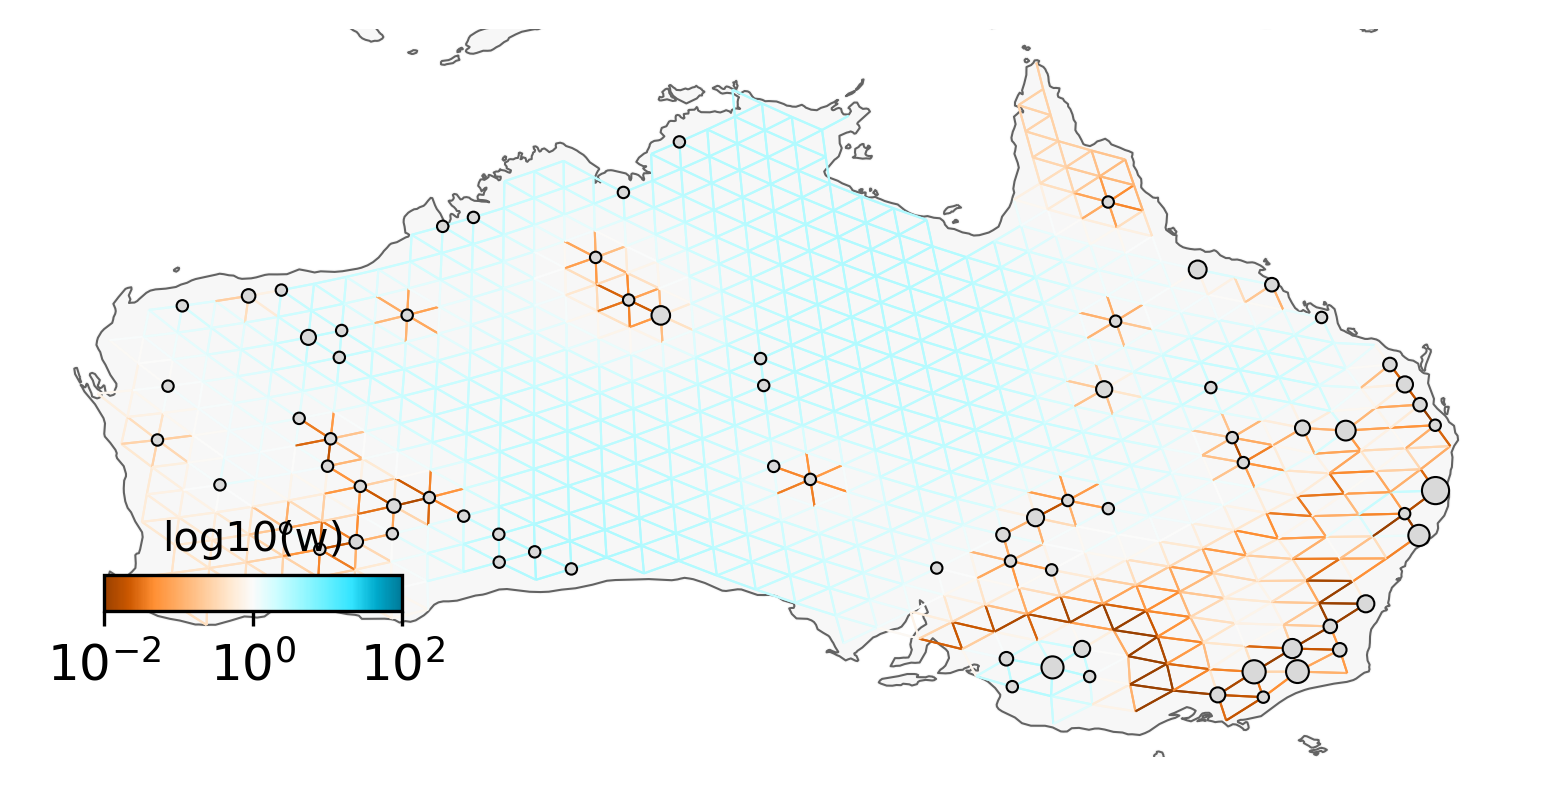

In [9]:
# Plot the map and grid. 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

In [10]:
# I do not like how the default output from feems looks like
# So the next few things are optional and I added them in there
# so that I can plot the output in R using my own map plotting code. 
import networkx as nx

# Extract the important information
num_w = len(sp_graph.w)
# I rummaged through the code and this is how they calculate the log weights
log_weights = np.log10(sp_graph.w) - np.mean(np.log10(sp_graph.w))

# Get edges 
num_edges = len(sp_graph.edges)

# Get node positions
num_node_pos = len(sp_graph.node_pos)

# Get observed nodes and thier size
num_observed_nodes = sp_graph.n_observed_nodes
d = nx.get_node_attributes(sp_graph, "permuted_idx")
arr = np.array(list(d.values()))
obs_perm_ids = arr[: sp_graph.n_observed_nodes]
size_of_nodes = 10 * np.sqrt(sp_graph.n_samples_per_obs_node_permuted)

print(f"{num_node_pos} nodes with {num_edges} edges with {num_w} weights. Out of these {num_observed_nodes} nodes are observed!")

612 nodes with 1708 edges with 1708 weights. Out of these 74 nodes are observed!


In [15]:
# Save all the output as separate csv files.
# You can open these files in the R script to make a pretty plot. 
import pandas as pd

# Save Weights
weights_df = pd.DataFrame(sp_graph.w, columns=['Weight'])
weights_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/weights.csv', index=True)
# corrected 
weights_corr_df = pd.DataFrame(log_weights, columns=['Weight'])
weights_corr_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/corrected_weights.csv', index=True)

# Save nodes
nodes_df = pd.DataFrame(sp_graph.node_pos, columns=['Longitude', 'Latitude'])
nodes_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/node_pos.csv', index=True)

# Save edges
edges_df = pd.DataFrame(sp_graph.edges, columns=['Node1_ID', 'Node2_ID'])
edges_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/edges_pos.csv', index=True)

# Save observed nodes
obs_nodes_df = pd.DataFrame(obs_perm_ids, columns=['NodeID'])
obs_nodes_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/observed_nodes.csv', index=True)

# Save sizes of observed nodes
sizes_df = pd.DataFrame(size_of_nodes, columns=['Size'])
sizes_df.to_csv('/gpfs/users/a1880987/projects/dingo/feems/size_observed_nodes.csv', index=True)


In [16]:
# I am messing about here trying to understand how the weights are calculated
# You can ignore everything from here. 
W = sp_graph.inv_triu(sp_graph.w, perm=False)
w = np.array([])
idx = nx.adjacency_matrix(sp_graph).nonzero()
idx = list(np.column_stack(idx))
for i in range(len(idx)):
    w = np.append(w, W[idx[i][0], idx[i][1]])



In [18]:
print(f"{max(w)} and {min(w)}")

12.381641205105053 and 0.004083231106721331


In [ ]:
print(f"{max(sp_graph.w)} and ")